In [191]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Загрузка, фильтрация

In [192]:
def remove_generic_indicators(df: pd.DataFrame):
    df["method"] = df["method"].map(lambda method: method.replace("`1", ""))
    return df


def prepare_nn_res(nn_res_df: pd.DataFrame) -> pd.DataFrame:
    return nn_res_df.rename(
        lambda x: f"{x}__nn" if x != "method" else "method", axis="columns"
    )


def prepare_heu_res(heu_res: pd.DataFrame) -> pd.DataFrame:
    return remove_generic_indicators(heu_res)

In [193]:
nn_res_path = "/Users/emax/Data/python/vsharp_searcher_bench/2023_12_22_10:27:33_127528_797_Adam_0_0002277922061785549_KLDL.log"
heuristic_res_path = "/Users/emax/Data/python/vsharp_searcher_bench/ExecutionTreeContributedCoverage_all.csv"

from parse_pretty import parse_pretty

In [194]:
with open(nn_res_path, "r") as pretty_file:
    nn_df = parse_pretty(pretty_file.readlines())
heu_df = pd.read_csv(heuristic_res_path)

nn_df = prepare_nn_res(nn_df)
heu_df = prepare_heu_res(heu_df)

heu_df = heu_df.drop(["total_time_sec", "timeouted"], axis=1)
...

Ellipsis

Не будем учитывать вхождения, на которых coverage_tool не запустился:

In [195]:
def drop_failed_heu(df: pd.DataFrame) -> int:
    failed = df[(df["coverage"] == -1)].index
    return failed


def drop_failed_nn(df: pd.DataFrame) -> int:
    failed = df[(df["coverage__nn"] == -1)].index
    return failed


heu_df = heu_df.drop(drop_failed_heu(heu_df))
nn_df = nn_df.drop(drop_failed_nn(nn_df))

In [196]:
heu_df.describe()

,steps,tests,errors,coverage
count,205.000000,205.000000,205.000000,205.000000
mean,2483.526829,2.892683,7.951220,71.268293
std,2289.475528,3.901759,21.377502,35.492214
min,13.000000,0.000000,0.000000,0.000000
25%,146.000000,1.000000,1.000000,52.000000
50%,1620.000000,2.000000,3.000000,89.000000
75%,5000.000000,3.000000,7.000000,100.000000
max,5001.000000,31.000000,230.000000,100.000000


In [197]:
nn_df.describe()

,steps__nn,tests__nn,errors__nn,coverage__nn
count,148.000000,148.000000,148.000000,148.000000
mean,1644.486486,2.209459,2.648649,65.885135
std,2119.510460,2.577383,3.802729,43.913261
min,0.000000,0.000000,0.000000,0.000000
25%,49.000000,0.750000,0.000000,0.000000
50%,288.500000,1.000000,1.000000,100.000000
75%,5000.000000,3.000000,4.000000,100.000000
max,5000.000000,13.000000,20.000000,100.000000


In [198]:
inner_df = heu_df.merge(nn_df, on="method", how="inner")
outer_df = heu_df.merge(nn_df, on="method", how="outer")

In [199]:
# outer_df[(outer_df["coverage"].isna()) & ~(outer_df["coverage__nn"].isna())]
# outer_df[~(outer_df["coverage"].isna()) & (outer_df["coverage__nn"].isna())]
...

Ellipsis

## Метрики

Распределение:

In [200]:
def stats(ser: pd.Series) -> tuple:
    return {
        "mean": round(ser.mean(), 2),
        "median": round(ser.median(), 2),
        "std": round(ser.std(), 2),
    }


print("Coverage:")
print("heuristic:".ljust(10), stats(inner_df["coverage"]))
print("nn:".ljust(10), stats(inner_df["coverage__nn"]))

print("\nTests:")
print("heuristic:".ljust(10), stats(inner_df["tests"]))
print("nn:".ljust(10), stats(inner_df["tests__nn"]))

print("\nSteps:")
print("heuristic:".ljust(10), stats(inner_df["steps"]))
print("nn:".ljust(10), stats(inner_df["steps__nn"]))

print("\nErrors:")
print("heuristic:".ljust(10), stats(inner_df["errors"]))
print("nn:".ljust(10), stats(inner_df["errors__nn"]))

Coverage:
heuristic: {'mean': 75.75, 'median': 100.0, 'std': 33.09}
nn:        {'mean': 65.95, 'median': 100.0, 'std': 44.08}

Tests:
heuristic: {'mean': 3.64, 'median': 2.0, 'std': 4.58}
nn:        {'mean': 2.31, 'median': 1.5, 'std': 2.59}

Steps:
heuristic: {'mean': 2889.18, 'median': 3814.5, 'std': 2193.42}
nn:        {'mean': 1408.75, 'median': 265.5, 'std': 1982.65}

Errors:
heuristic: {'mean': 9.95, 'median': 3.0, 'std': 26.6}
nn:        {'mean': 2.85, 'median': 1.0, 'std': 4.11}


In [201]:
inner_hundred = inner_df.loc[inner_df["coverage"] == 100]
inner_hundred = inner_hundred.loc[inner_df["coverage__nn"] == 100]
inner_hundred.head()

,method,steps,tests,errors,coverage,steps__nn,tests__nn,errors__nn,coverage__nn
0,BinarySearch,433,7,1,100.0,303,7,1,100.0
5,Switches5,1107,5,6,100.0,716,5,3,100.0
6,NestedFors,125,2,0,100.0,49,2,0,100.0
8,BellmanFord,4217,6,13,100.0,267,4,11,100.0
10,determinant,1620,3,4,100.0,390,3,4,100.0


## Сравнение с покрытием в 100%

### Шаги

<Axes: xlabel='steps', ylabel='Count'>

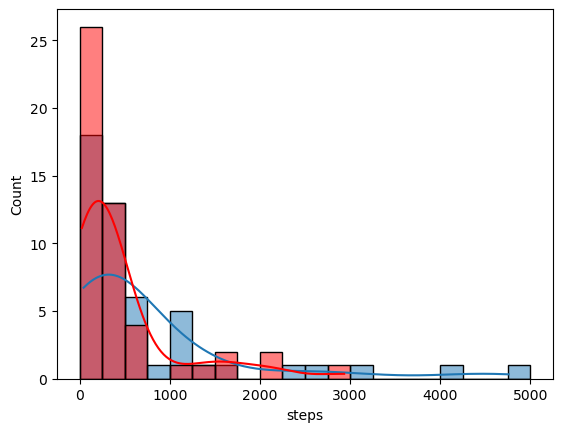

In [209]:
fig, ax = plt.subplots()

sns.histplot(
    data=inner_hundred, x="steps", bins=20, kde=True, ax=ax, binrange=(0, 5000)
)
sns.histplot(
    data=inner_hundred,
    x="steps__nn",
    bins=20,
    kde=True,
    ax=ax,
    color="red",
    binrange=(0, 5000),
)

### Тесты

<Axes: xlabel='tests', ylabel='Count'>

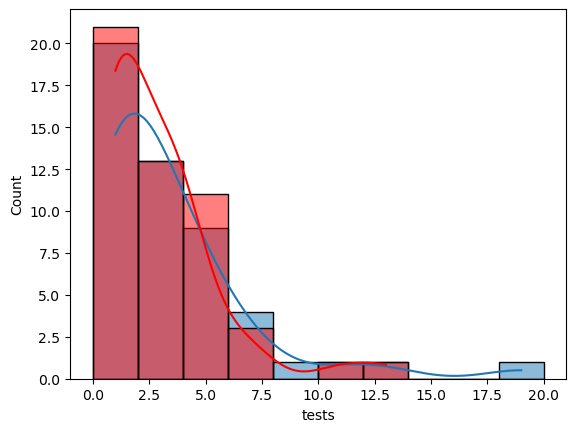

In [213]:
fig, ax = plt.subplots()

sns.histplot(data=inner_hundred, x="tests", bins=10, kde=True, ax=ax, binrange=(0, 20))
sns.histplot(data=inner_hundred, x="tests__nn", bins=10, kde=True, ax=ax, color="red", binrange=(0, 20))

### Ошибки

<Axes: xlabel='errors', ylabel='Count'>

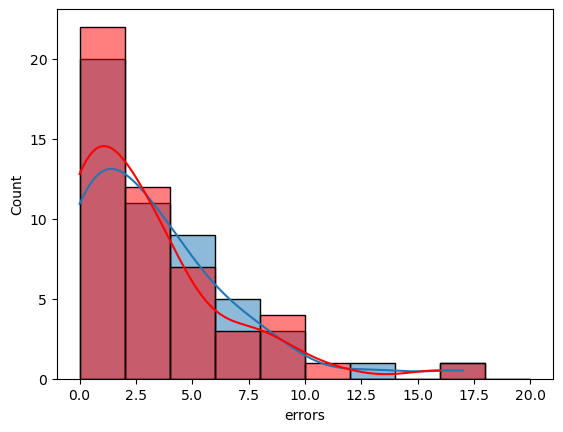

In [214]:
fig, ax = plt.subplots()

sns.histplot(data=inner_hundred, x="errors", bins=10, kde=True, ax=ax, binrange=(0, 20))
sns.histplot(data=inner_hundred, x="errors__nn", bins=10, kde=True, ax=ax, color="red", binrange=(0, 20))

## Распределение покрытий

<Axes: xlabel='coverage', ylabel='Count'>

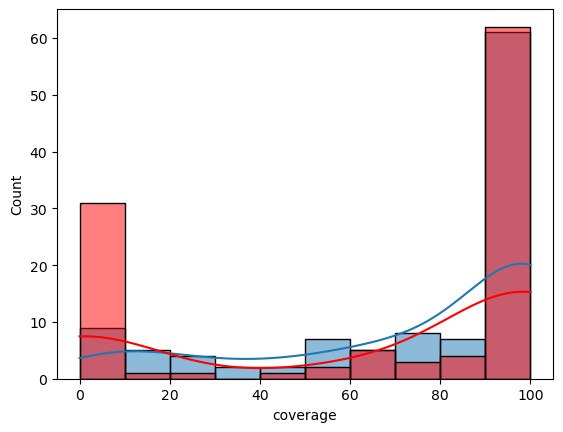

In [215]:
fig, ax = plt.subplots()

sns.histplot(data=inner_df, x="coverage", bins=10, kde=True, ax=ax, binrange=(0, 100))
sns.histplot(data=inner_df, x="coverage__nn", bins=10, kde=True, ax=ax, color="red", binrange=(0, 100))